# Deep learning-based optimal filter design for compressed Raman cell type classification 

## Imports

In [468]:
import pandas as pd
from os import listdir
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.cluster import hierarchy

from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from random import sample
import pickle
from time import time

np.random.seed(42)
tf.random.set_seed(42)



## Definitions

In [469]:
# define a colorblind-friendly palette
mypalette = ['xkcd:royal blue','xkcd:orange red','xkcd:golden yellow','xkcd:light grey']

def panel_label(ax,label,fontsize=32):
    """Adds panel to label"""
    ax.text(-0.01, 1.1,label,transform=ax.transAxes,
      fontsize=fontsize, fontweight='bold', va='top', ha='right')

def plot_error(spectra_plot,ax,label,color,error='mad'):
    
    if error == 'mad':
        spectra_median = spectra_plot.median(axis=0)
        spectra_dev = (spectra_plot - spectra_median)

        upper = spectra_median + (spectra_dev*(spectra_dev > 0)).sum(axis=0)/(spectra_dev > 0).sum(axis=0)
        lower = spectra_median - (-spectra_dev*(spectra_dev < 0)).sum(axis=0)/(spectra_dev < 0).sum(axis=0)
        
        spectra_stat = spectra_median

    if error == 'sd':
        spectra_mean = spectra_plot.mean(axis=0)
        spectra_dev = (spectra_plot - spectra_mean)

        upper = spectra_mean + np.sqrt(((spectra_dev*(spectra_dev > 0))**2).sum(axis=0)/(spectra_dev > 0).sum(axis=0)) 
        lower = spectra_mean - np.sqrt(((spectra_dev*(spectra_dev < 0))**2).sum(axis=0)/(spectra_dev < 0).sum(axis=0)) 
        
        spectra_stat = spectra_mean

    
    ax.plot(spectra_plot.columns.values, spectra_stat, label=label,lw=3,color=color)
    ax.plot(spectra_plot.columns.values, lower,color=color, alpha=0.1)
    ax.plot(spectra_plot.columns.values, upper,color=color, alpha=0.1)
    ax.fill_between(spectra_plot.columns.values, lower, upper,color=color,alpha=0.2) 
    

def split_data(spectra):
    
    """
    Split data into Raman intensities and meta data
    """
    
    spectra_ctype = spectra.groupby(['ctype']).mean().iloc[:,:-3]
    spectra_ctype.columns = spectra_ctype.columns.astype(float)
    spectra_ctype_std = spectra.groupby(['ctype']).std().iloc[:,:-3]
    spectra_ctype_std.columns = spectra_ctype_std.columns.astype(float)

    spectra_cell = spectra.groupby(['date','rep','cline','ctype','count']).mean()
    spectra_cell.columns = spectra_cell.columns.astype(float)

    meta = spectra.iloc[:,-5:]
    meta['ctype'] = meta['ctype'].astype('category').cat.reorder_categories(['iPSC','NSC','Neuron'])

    meta_cell = spectra_cell.reset_index().iloc[:,:5]
    meta_cell['ctype'] = meta_cell['ctype'].astype('category').cat.reorder_categories(['iPSC','NSC','Neuron'])

    spectra = spectra.iloc[:,:-5]
    spectra.columns = spectra.columns.astype(float)
    
    return spectra, spectra_cell,spectra_ctype,meta, meta_cell

    
def baseline_als(y, lam, p, niter=10):
    
    """
    Baseline removal by asymmetric least squares smoothing introduced by
    PHC Eilers, HFM Boelens (Leiden University Medical Centre Report 1 (1), 5).
    See also: He, S. et al. Baseline correction for Raman spectra using an improved 
    asymmetric least squares method. Anal Methods-uk 6, 4402–4407 (2014).
    
    PARAMETERS
    y: input data
    lam: prefactor of smoothness penalty term (result is smoother if lam is bigger)
    p: asymmetry parameter; weights on deviations are p if deviation is positive, 1-p
        if deviation is negative
    niter: number of iterations of smoothing procedure; weights are updated in each iteration
        
    RETURNS
    z: smoothed input data 
    """
    
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
        
    return z


def train_svm(X,y,norm=True,random_state=None):
    """
    Classifies data using SVM. 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct prediction (boolean)
    
    """
    
    if norm:
        X = StandardScaler().fit_transform(X)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state)

    model = svm.SVC()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    return accuracy_score(y_test,y_pred), y_test.index,y_pred==y_test,y_pred,y_test



 
def train_nn(X,y,random_state=None):

    """
    Classifies data using NN 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct prediction (boolean)
    
    """

    X = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)
    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()

    with mirrored_strategy.scope():
        
        model = keras.models.Sequential([
            keras.Input(shape=(X_train.shape[1],)),
            keras.layers.Dense(10,activation="relu"),
            keras.layers.Dense(3,activation="softmax")])    

        model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                      optimizer=keras.optimizers.SGD(learning_rate=0.01),
                      metrics=['accuracy'])


        history = model.fit(X_train,y_train,epochs=60,validation_split=0.25,
                            verbose=0,batch_size=32,
                            use_multiprocessing=True, workers=8)
        

        y_pred = model.predict(X_test,verbose=0)

        acc = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return acc,y_test.index,y_test==np.argmax(y_pred,1),np.argmax(y_pred,1),y_test,history


class BinaryWeights(tf.keras.constraints.Constraint):
  """Constrains weight tensors to be binary but non-zero value is variable"""

  def __call__(self,w):
    
    m = tf.reduce_mean(w,axis=0)
    ind = tf.cast(tf.math.greater(w, m),w.dtype)
    m = tf.math.divide(tf.reduce_sum(tf.math.multiply(w,ind),axis=0),tf.math.reduce_sum(ind,axis=0))
    
    return m*tf.cast(tf.math.greater(w, m/2),w.dtype)



def train_nn_filter(X,y,Nfilters=2,constraint='NonNeg',norm='layer',preweights=None,epochs=20,
                    batch_size=32,is_train = None,random_state=None,verbose=0):

    """
    Classifies spectra using an NN and Nfilters filters
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct predictions (boolean), weights, history
    
    """
    
    if is_train is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)
    else:
        X_train = X.loc[is_train,:]
        y_train = y.loc[is_train]
        X_test = X.loc[~is_train,:]
        y_test = y.loc[~is_train]
        
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train,random_state=random_state)
    
    mirrored_strategy = tf.distribute.MirroredStrategy()

    with mirrored_strategy.scope():
    
        if constraint == 'NonNeg':
            const = keras.constraints.NonNeg();
        elif constraint == 'Binary':
            const = BinaryWeights()    

        model = keras.models.Sequential([
            keras.Input(shape=(X_train.shape[1],)),
            keras.layers.Dense(Nfilters,
                             kernel_constraint = const,
                               kernel_initializer='HeUniform',
                               activation="relu"),
            (keras.layers.LayerNormalization() if norm == 'layer' 
             else keras.layers.BatchNormalization()),
            keras.layers.Dense(20,activation="relu",kernel_initializer='HeUniform'),
            keras.layers.Dense(20,activation="relu",kernel_initializer='HeUniform'),
            keras.layers.Dense(10,activation="relu",kernel_initializer='HeUniform'),
            keras.layers.Dense(5,activation="relu",kernel_initializer='HeUniform'),
            keras.layers.Dense(3,activation="softmax")    
        ])

        model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                      optimizer=keras.optimizers.SGD(learning_rate=0.01),
                      metrics=['accuracy'])

        if not (preweights is None):
            model.set_weights(preweights) 

        history = model.fit(X_train,y_train,epochs=epochs,validation_data=(X_val,y_val),verbose=verbose,batch_size=batch_size)

        y_pred = model.predict(X_test,verbose=0)

        acc = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return acc,y_test.index,y_test==np.argmax(y_pred,1),np.argmax(y_pred,1),y_test,model.get_weights(), history




## Parameters

In [470]:
# preprocessing parameters
lam = 1e6
p = 0.1
Nfreq = 443

# Preprocessing

We use the measured dat from: 
"Hsu, C.-C. et al. A single-cell Raman-based platform to identify developmental stages of human pluripotent stem cell-derived neurons. P Natl Acad Sci Usa 117, 18412–18423 (2020)." We follow Hsu et al and only consider Wavenumbers between 320 $cm^{-1}$ and 1800 $cm^{-1}$ (Fingerprint region). Failed measurements (= all zeros) are removed.

In [ ]:
# folder = './litdata/'
# files = listdir(folder)

# alldatraw = pd.DataFrame()
# allblines = pd.DataFrame()
# alldat = pd.DataFrame()


# colnames = ['freq_' +  str(i) for i in range(Nfreq)]

# count = 0
# for file in files:
    
#     count+=1

#     datraw = pd.read_csv(folder+file,sep='\t')

#     # Crop to fingerprint region
#     datraw = datraw.iloc[:,2:(Nfreq+2)]

#     # Remove rows with zeros        
#     datraw = datraw.loc[(datraw > 0).any(axis=1),:]                

#     # Remove baseline from each spectrum
    
#     blines = datraw.apply(lambda x : baseline_als(x,lam,p),axis=1,result_type='broadcast')
#     dat = datraw - blines

#     # Normalize
#     dat = dat.apply(lambda x : x/sum(x),axis=1)

#     for d in [datraw,blines,dat]:
#         d.columns = colnames
#         d['ctype'] = file.split('_')[0]
#         d['cline'] = file.split('_')[1]
#         d['rep'] = file.split('_')[2][1]
#         d['date'] = file.split('_')[3]
#         d['count'] = file.split('_')[4].split('.')[0]        

#     alldatraw = pd.concat([alldatraw,datraw],axis=0,ignore_index=True)
#     allblines = pd.concat([allblines,blines],axis=0,ignore_index=True)
#     alldat = pd.concat([alldat,dat],axis=0,ignore_index=True)


# # use frequencies as column names
# dat = pd.read_csv(folder+files[0],sep='\t')
# alldat.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)
# allblines.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)
# alldatraw.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)

# # save
# alldatraw.to_csv('raman_fingerprint_raw.csv')    
# allblines.to_csv('raman_fingerprint_baselines.csv')    
# alldat.to_csv('raman_fingerprint_processed.csv')    

## Unprocessed spectra

In [14]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

## Raw spectra by cell type

In [304]:
spectra_mean_df = pd.DataFrame({'log10(means)' : np.log10(spectra.mean(axis=1)), 'cell type' : meta.ctype})
spectra_combined = spectra.copy()
spectra_combined['cell type'] = meta.ctype
spectra_combined = spectra_combined.melt(id_vars=['cell type'],var_name='freq')
spectra_combined['cell type'] = spectra_combined['cell type'].cat.reorder_categories(['iPSC','NSC','Neuron'])

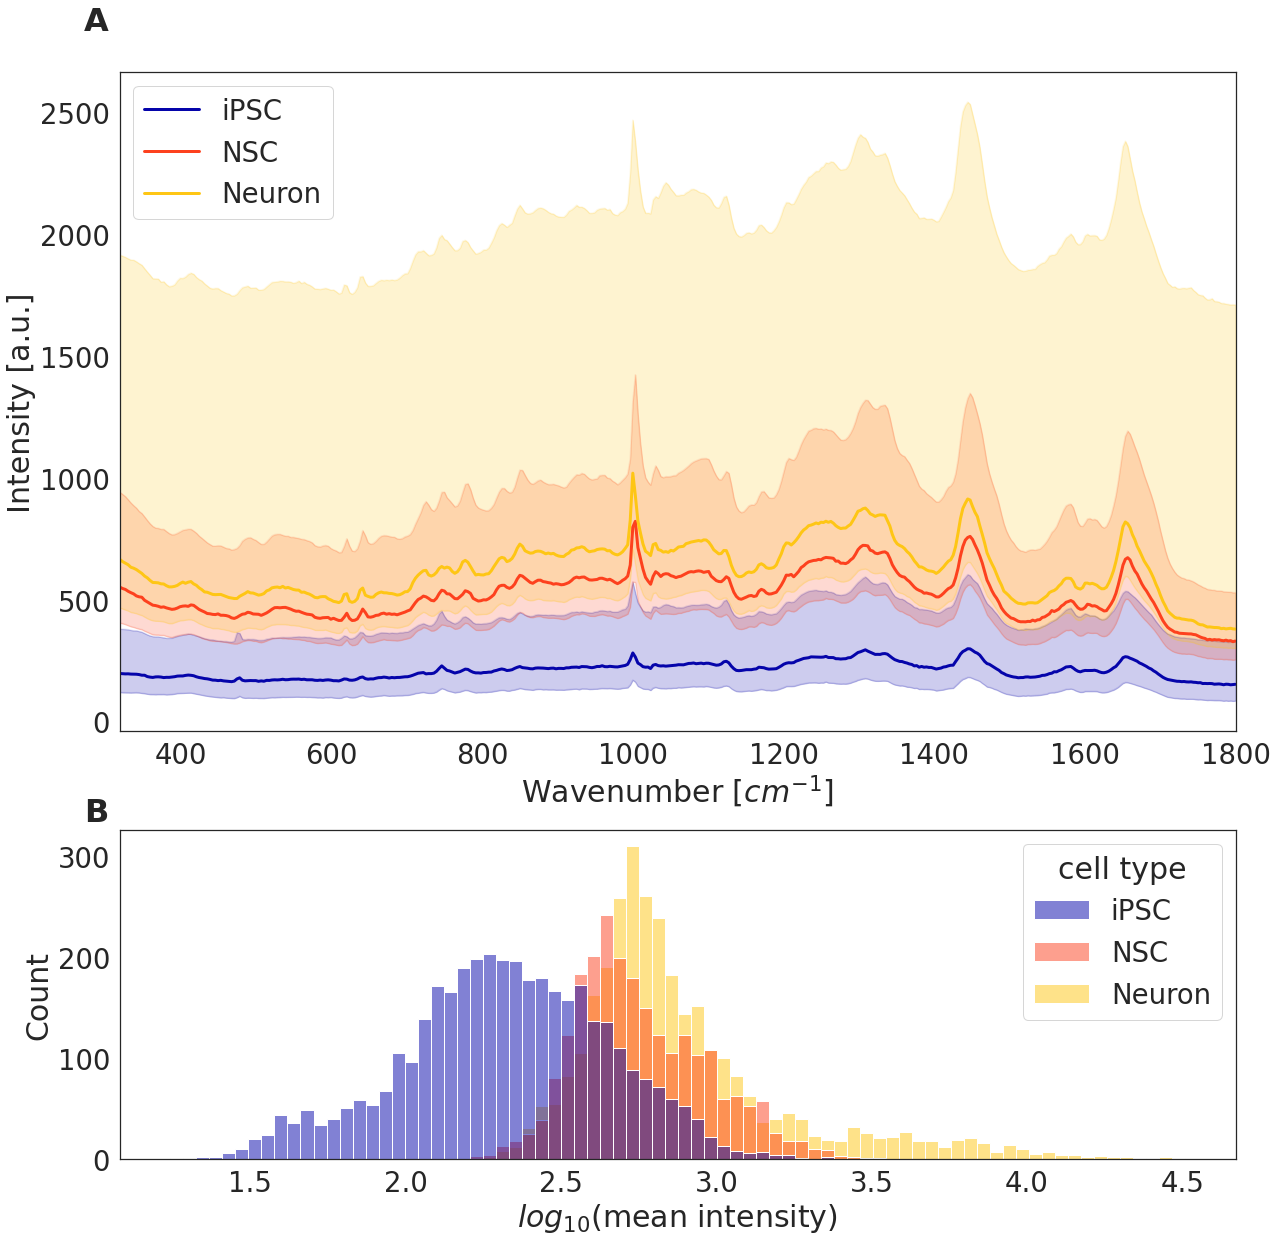

In [305]:
sns.set(style='white',font_scale=2.5)

fig, ax  = plt.subplots(figsize=[20,20],nrows=2,gridspec_kw={'height_ratios': [2, 1]})

panel_label(ax[0],'A')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:],ax[0],ctype,mypalette[ind],error='mad')

ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend()

panel_label(ax[1],'B')
sns.histplot(data=spectra_mean_df,x='log10(means)', hue='cell type',ax=ax[1],palette=mypalette)
ax[1].set_xlabel('$log_{10}$(mean intensity)');

fig.savefig('./figures/Fig2.png')

**Figure 1, Raw Raman spectra**
(A)Raman intensities by cell type before preprocessing The solid lines show the median per cell type for each frequency. The error bands indicate mean absolute deviations calculated separately for positive and negative deviations. (B) Mean intensities of individual Raman spectra before preprocessing.

## Preprocessing example

In [307]:
# load one spectrum as an example
folder = './litdata/'
files = listdir(folder)
dat = pd.read_csv(folder+files[0],sep='\t')

# Crop to fingerprint region
spectrum = dat.iloc[6,2:445]
spectrum.index = spectrum.index.astype(float)

# Calculate baseline
bline = baseline_als(spectrum,lam,p)

# Subtract baseline
spectrum_nobline = spectrum - bline

# Normalize spectrum
spectrum_normalized = spectrum_nobline/sum(spectrum_nobline)


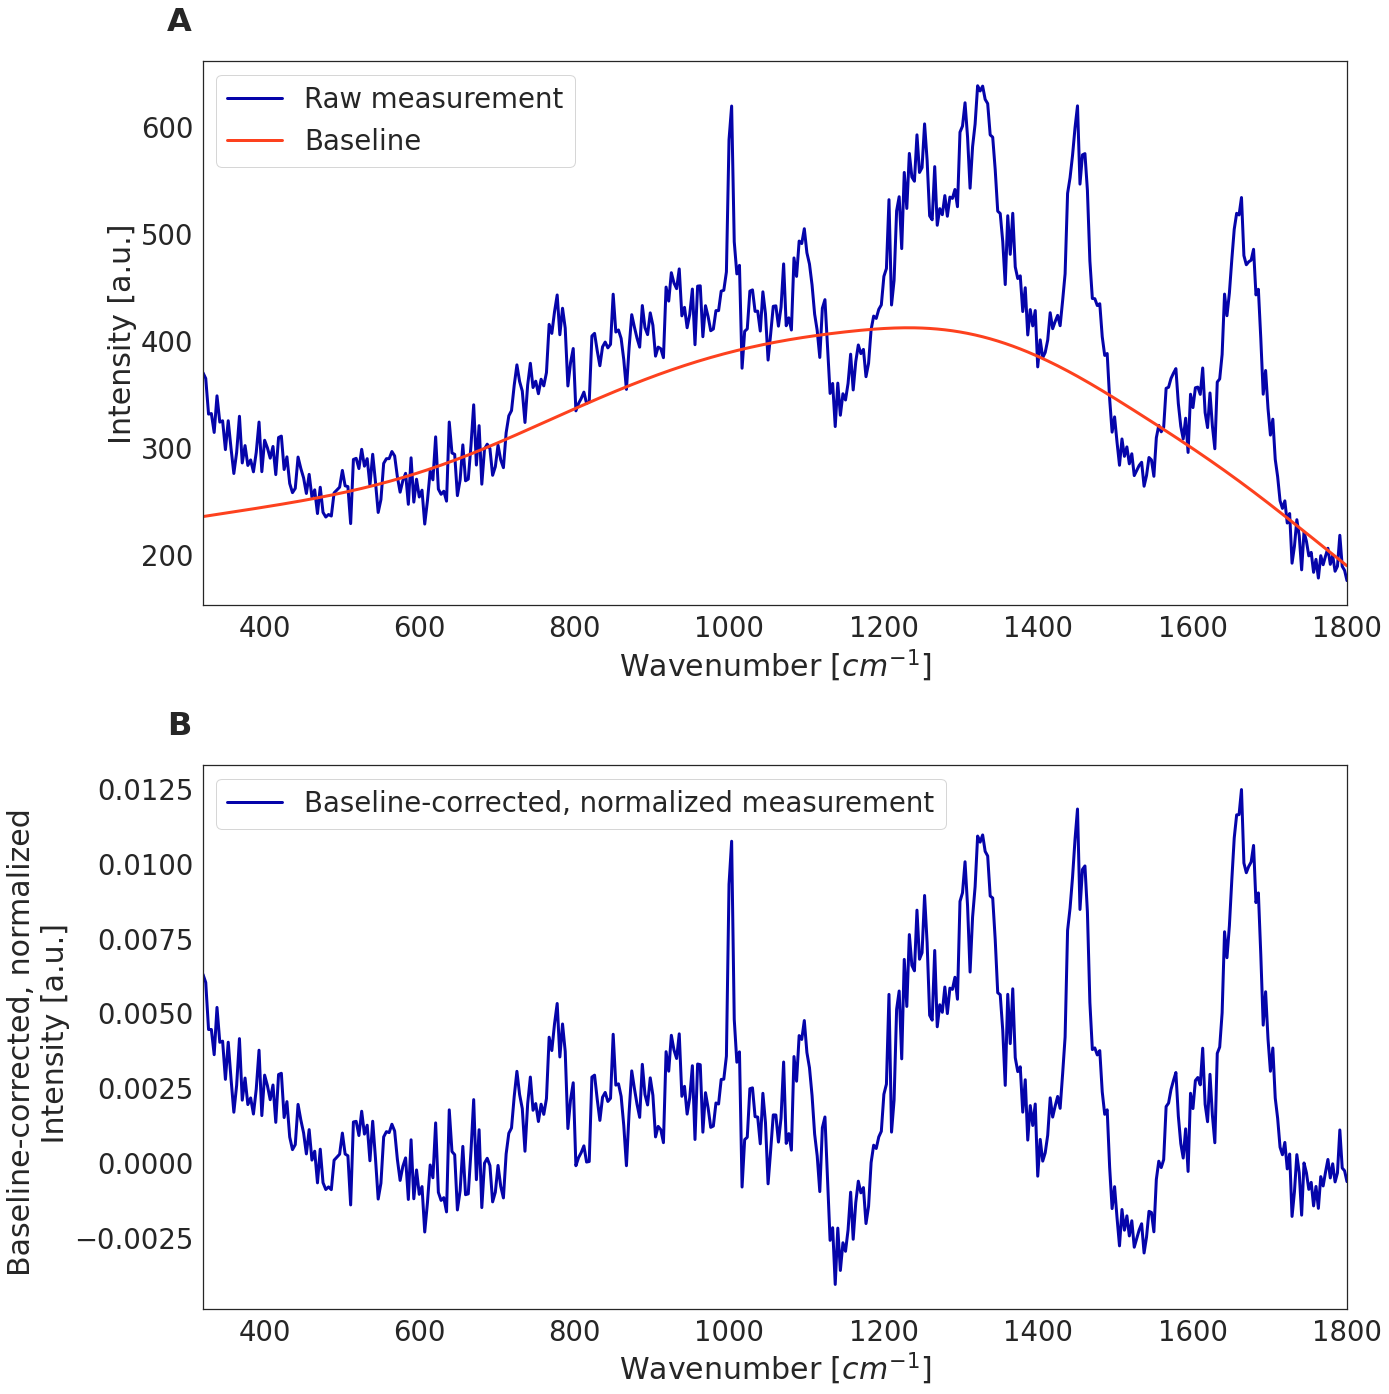

In [308]:
sns.set(style='white',font_scale=2.5)
fig, ax  = plt.subplots(figsize=[20,20],nrows=2)

panel_label(ax[0],'A')
ax[0].plot(spectrum,'-',color='xkcd:royal blue',lw=3,label='Raw measurement')
ax[0].plot(spectrum.index,bline,'-',color='xkcd:orange red',lw=3,label='Baseline')
ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend();

panel_label(ax[1],'B')
ax[1].plot(spectrum_normalized,'-',color='xkcd:royal blue',lw=3,
           label='Baseline-corrected, normalized measurement')
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('Baseline-corrected, normalized \n Intensity [a.u.]',wrap=True)
ax[1].set_xlim([319,1800])
ax[1].legend();
fig.tight_layout()
fig.savefig('./figures/FigS1.png')

**Figure S1, Preprocessing example**
(A) A baseline calculated by asymmetric least-squares smoothing (red) is subtracted from the raw measurement (blue). (B) The baseline-corrected measurement shown is normalized to the sum of intensities over all considered frequencies.


## Processed spectra by cell type

In [309]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [310]:
# get number of measurements per cell type
stats_df = pd.DataFrame(meta.groupby('ctype').size()).T
stats_df.columns.name = None
stats_df.index = ['measurements']
stats_df

,iPSC,NSC,Neuron
measurements,3850,2342,3116


In [311]:
# combine spectra and change to long form for visualization
spectra_combined = spectra.copy()
spectra_combined['cell type'] = meta.ctype
spectra_combined = spectra_combined.melt(id_vars=['cell type'],var_name='freq')
spectra_combined['cell type'] = spectra_combined['cell type'].cat.reorder_categories(['iPSC','NSC','Neuron'])

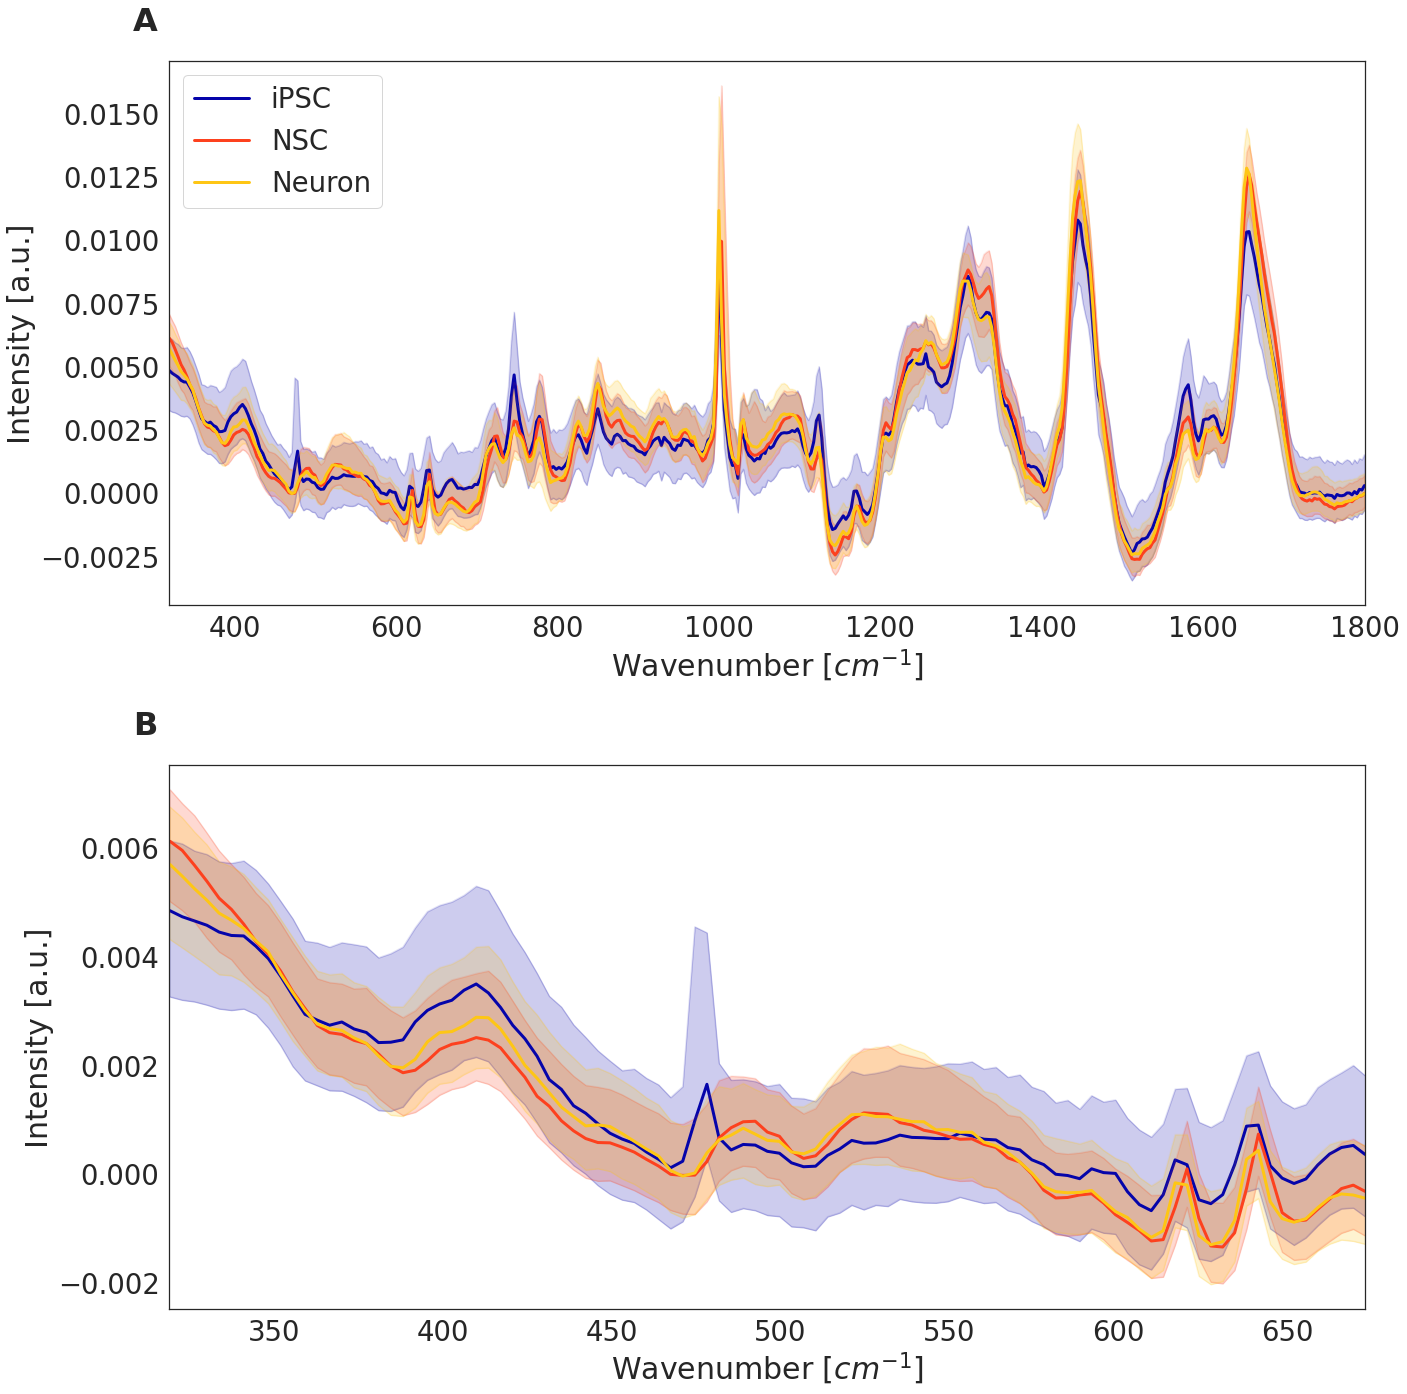

In [312]:
sns.set(style='white',font_scale=2.5)
fig, ax  = plt.subplots(figsize=[20,20],nrows=2)

panel_label(ax[0],'A')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:],ax[0],ctype,mypalette[ind],error='mad')

ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend()

panel_label(ax[1],'B')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:].iloc[:,:100],ax[1],ctype,mypalette[ind],error='mad')
    
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('Intensity [a.u.]')
ax[1].set_xlim([319,673])
fig.tight_layout()
fig.savefig('./figures/FigS2.png')

**Figure S2, Raman spectra of iPSCs, NSCs and Neurons are strongly overlapping**
Raman spectra after preprocessing (baseline removal and normalization. The solid lines show the medians per cell type (3850 for iPSCS, 2342 for NSCs and 3116 for Neurons). Error bands indicate mean absolute deviation calculated separately for positive and negative deviations. (A) Complete fingerprint region. (B) Zoom in on 319  to 673 $cm^{-1}$.

# Classification based on complete spectra

In [37]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [38]:
# code cell types as integers
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

## PCA and tSNE

In [39]:
pca = PCA(n_components=10).fit_transform(spectra)

pca_df = pd.DataFrame(pca[:,:2])
pca_df.columns = ['PC1','PC2']
pca_df['cell type'] = meta['ctype']

tsne_map = TSNE().fit_transform(pca)
tsne_map_df = pd.DataFrame(tsne_map)
tsne_map_df.columns = ['tSNE1','tSNE2']
tsne_map_df['cell type'] = meta['ctype']


/home/ssemrau/anaconda3/envs/RAMAN/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ssemrau/anaconda3/envs/RAMAN/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Training

In [99]:
Nreps = 5

all_acc_svm = list()
all_acc_nn = list()
all_ypred_svm = list()
all_ytest_svm = list()
all_ypred_nn = list()
all_ytest_nn = list()


for i in range(Nreps):
    acc_svm,index_svm,is_correct_svm,y_pred_svm,y_test_svm = train_svm(spectra,y)
    acc_nn,index_nn,is_correct_nn,y_pred_nn,y_test_nn,history = train_nn(spectra,y)
    
    all_acc_svm.append(acc_svm)
    all_acc_nn.append(acc_nn)
    
    all_ypred_svm += list(y_pred_svm)
    all_ytest_svm += list(y_test_svm)
    all_ypred_nn  += list(y_pred_nn)
    all_ytest_nn += list(y_test_nn)
    

print([np.mean(all_acc_svm),np.mean(all_acc_nn)])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
[0.9145005370569279, 0.8974221229553223]


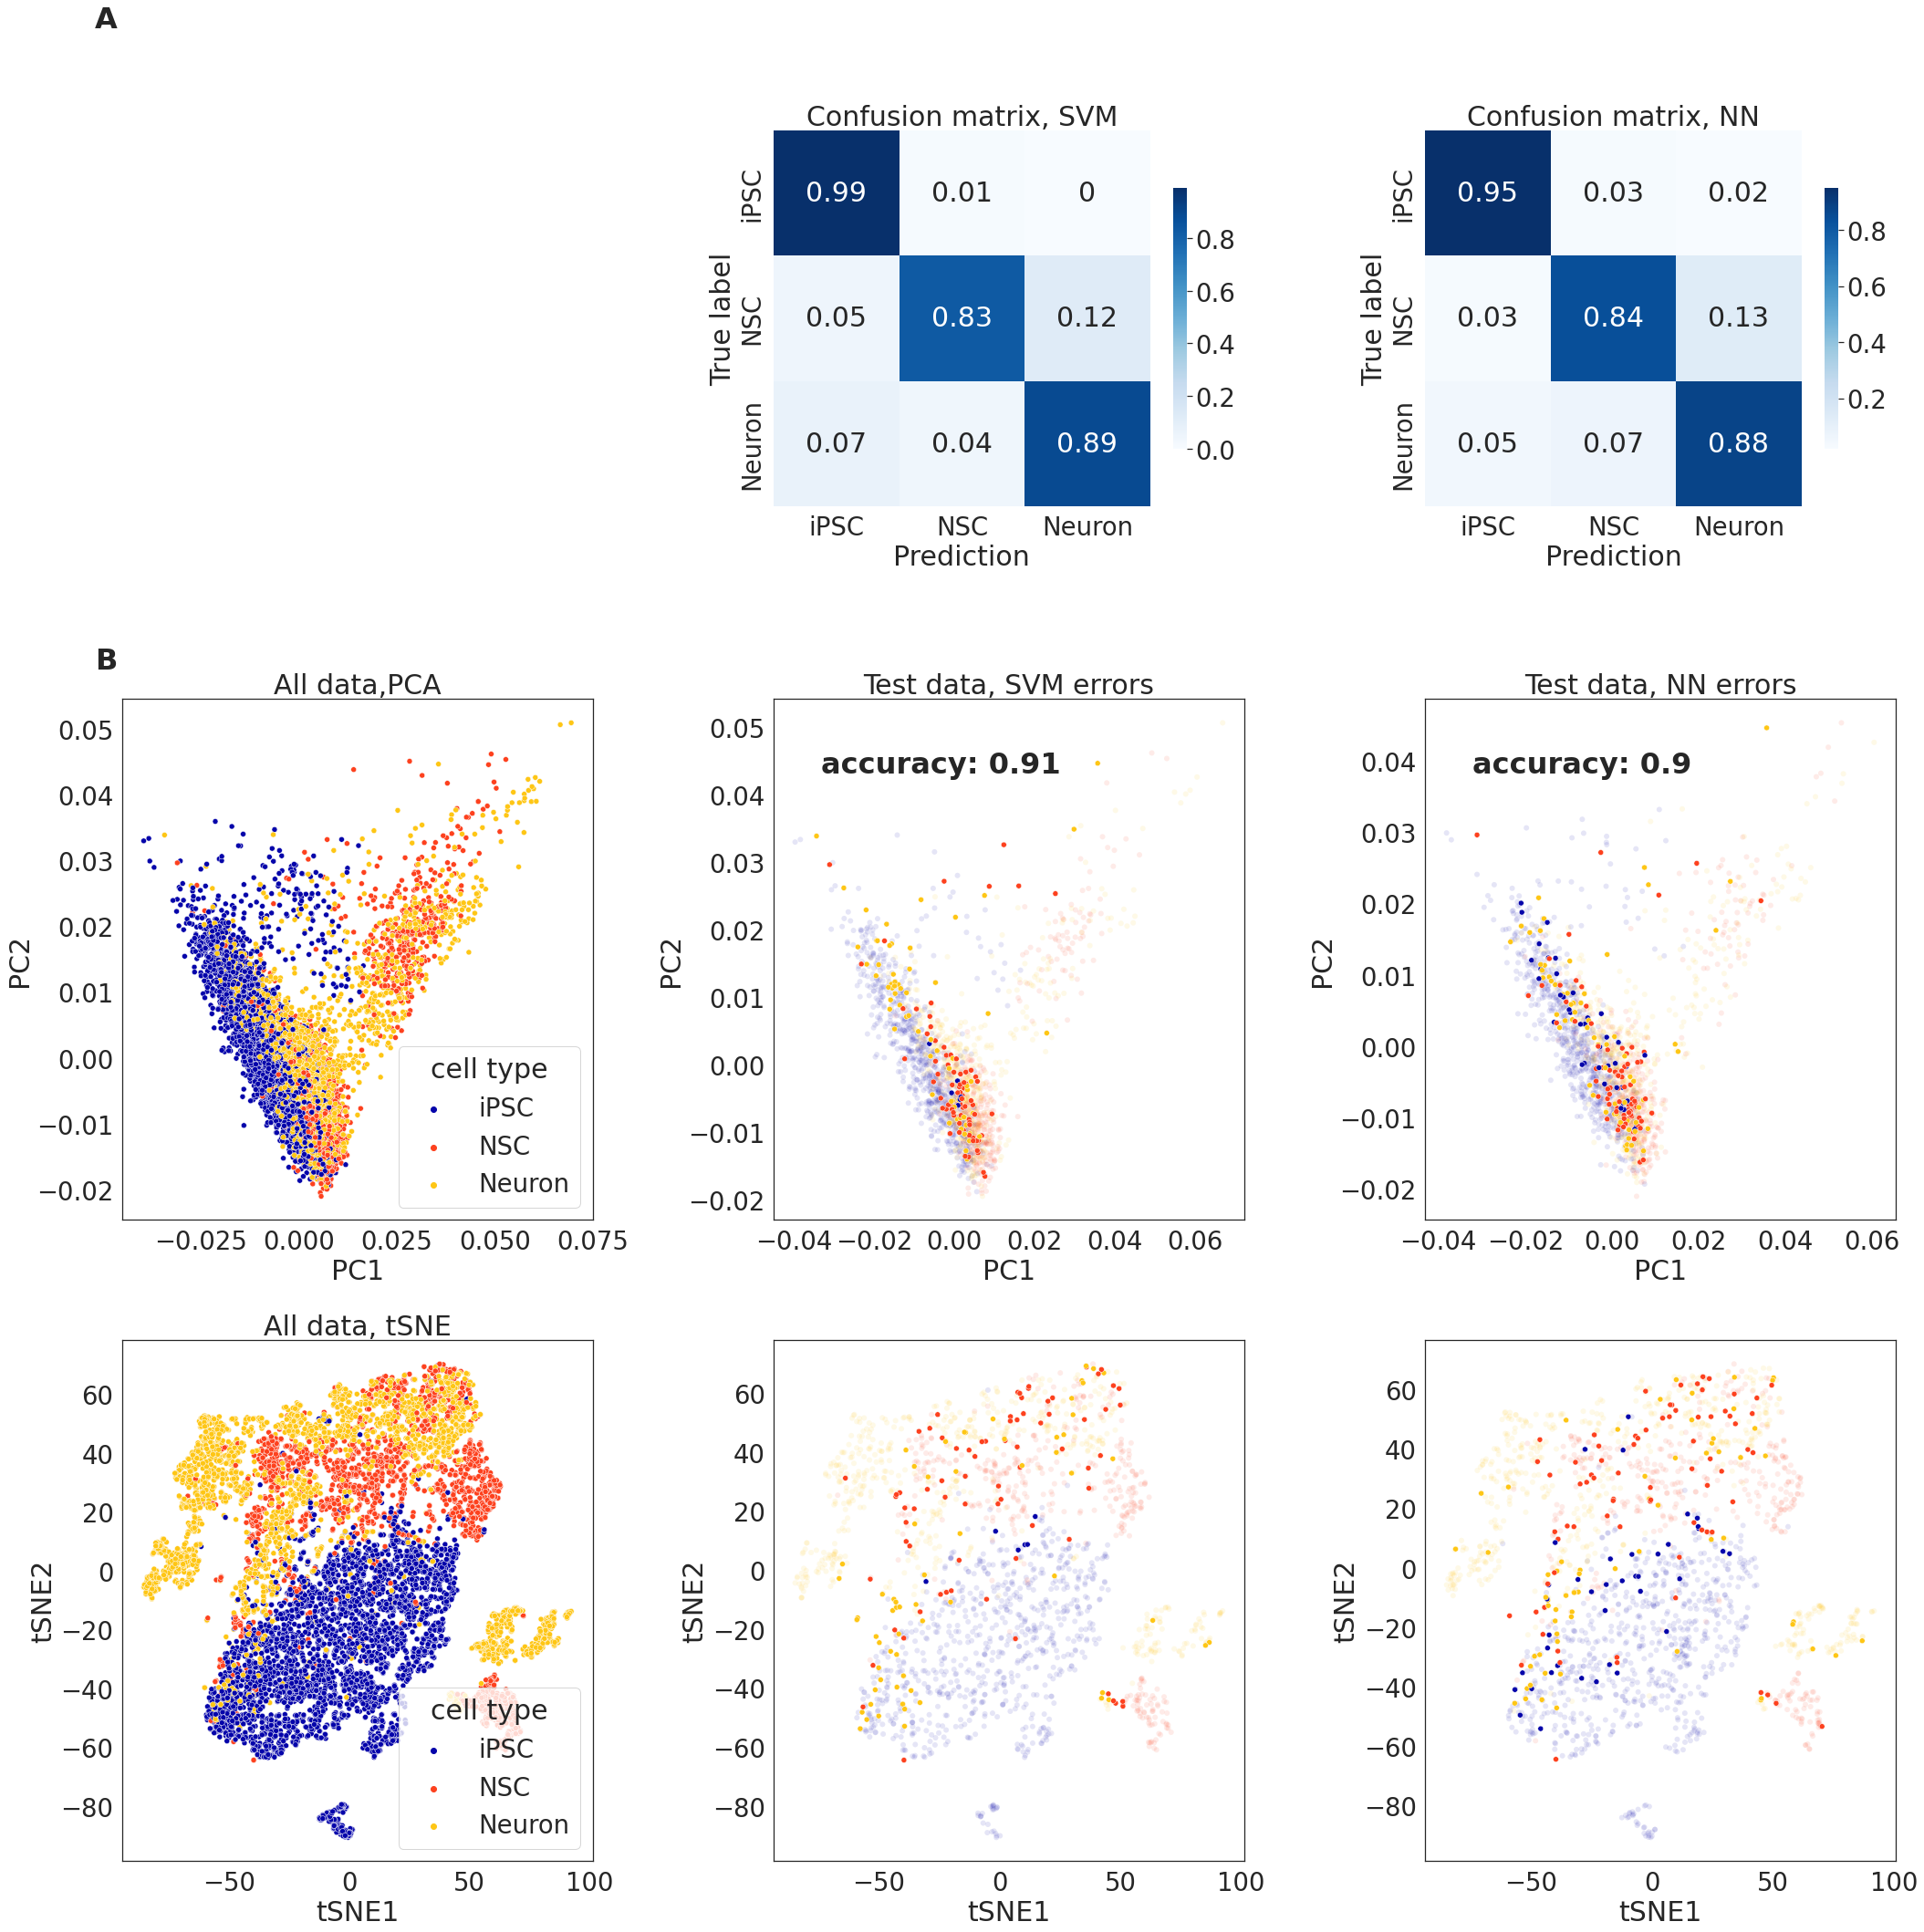

In [102]:
sns.set(style='white',font_scale=2.5)

fig,ax  = plt.subplots(figsize=[30,30],nrows=3,ncols=3)
# gridspec_kw={'height_ratios': [2, 1]}

panel_label(ax[0,0],'A')

conf_svm = np.round(confusion_matrix(all_ytest_svm,all_ypred_svm,labels = [0,1,2],normalize='true'),2)
conf_nn = np.round(confusion_matrix(all_ytest_nn,all_ypred_nn,labels = [0,1,2],normalize='true'),2)


s = sns.heatmap(conf_svm,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax[0,1])

s.set(xlabel='Prediction', ylabel='True label')


ax[0,1].set_title('Confusion matrix, SVM');


s = sns.heatmap(conf_nn,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax[0,2])

s.set(xlabel='Prediction', ylabel='True label')

ax[0,2].set_title('Confusion matrix, NN');

ax[0,0].axis('off')
# ax[0,0].get_xaxis().set_visible(False)
# ax[0,0].get_yaxis().set_visible(False)


# show dim reduction

sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='cell type',ax=ax[1,0],palette = mypalette[:3]);
ax[1,0].set_title('All data,PCA')

sns.scatterplot(data=tsne_map_df,x='tSNE1',y='tSNE2',hue='cell type',palette = mypalette[:3],ax=ax[2,0])
ax[2,0].set_title('All data, tSNE')

# wrong predictions SVM

panel_label(ax[1,0],'B')


pca_test_df = pca_df.loc[index_svm,:]



sns.scatterplot(data=pca_test_df.loc[is_correct_svm,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,1],palette = mypalette[:3],alpha=0.1)
sns.scatterplot(data=pca_test_df.loc[~is_correct_svm,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,1],palette = mypalette[:3],alpha=1)

ax[1,1].set_title('Test data, SVM errors');
ax[1,1].text(0.1, 0.9,'accuracy: '+str(np.round(np.mean(all_acc_svm),2)),
                        transform=ax[1,1].transAxes,
                        fontsize=32, fontweight='bold', va='top', ha='left')

ax[1,1].get_legend().remove()

tsne_map_test_df = tsne_map_df.loc[index_svm,:]

sns.scatterplot(data=tsne_map_test_df.loc[is_correct_svm,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                            palette = mypalette[:3],ax=ax[2,1],alpha=0.1)
sns.scatterplot(data=tsne_map_test_df.loc[~is_correct_svm,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                            palette = mypalette[:3],ax=ax[2,1],alpha=1)


ax[2,1].get_legend().remove()

# wrong predictions NN

pca_test_df = pca_df.loc[index_nn,:]


sns.scatterplot(data=pca_test_df.loc[is_correct_nn,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,2],palette = mypalette[:3],alpha=0.1)
sns.scatterplot(data=pca_test_df.loc[~is_correct_nn,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,2],palette = mypalette[:3],alpha=1)

ax[1,2].set_title('Test data, NN errors');
ax[1,2].text(0.1, 0.9,'accuracy: '+str(np.round(np.mean(all_acc_nn),2)),
                         transform=ax[1,2].transAxes,
                         fontsize=32, fontweight='bold', va='top', ha='left')

ax[1,2].get_legend().remove()

tsne_map_test_df = tsne_map_df.loc[index_nn,:]

sns.scatterplot(data=tsne_map_test_df.loc[is_correct_nn,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                palette = mypalette[:3],ax=ax[2,2],alpha=0.1)

sns.scatterplot(data=tsne_map_test_df.loc[~is_correct_nn,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                palette = mypalette[:3],ax=ax[2,2],alpha=1)


ax[2,2].get_legend().remove()

plt.tight_layout()

fig.savefig('./figures/FigS3.png')


**Figure S3, Support vector machines and neural networks classify cell types with high accuracy**
Supervised classification based on the complete Raman spectra in the fingerprint region. The first row shows the data projected on the first two principal components. The second row shows a two dimensional tSNE (t-distributed stochastic neighbor embedding). The second and third columns only show the test samples with the samples wrongly predicted by support vector classification or neural networks highlighted. 



# Classification based on spectra subsets or binned spectra 

### Subset of frequencies
SVM and NN classification using a subset of frequencies or frequency bands according to variability

In [318]:
# fraction of frequencies with highest variability
tops = [0.001,0.0025,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.5,1]

In [319]:
std = spectra_ctype.std(axis=0)

top_freqs_df = pd.DataFrame(columns = ['top','freq'])

for top in tops:
    q = np.quantile(std,1-top)
    top_freqs = std[std >= q].index.values #[np.int(s.split('_')[1]) for s in ]

    top_freqs_df = pd.concat([top_freqs_df,
                              pd.DataFrame( {'top' : top*np.ones(len(top_freqs)), 'freq' : top_freqs})])


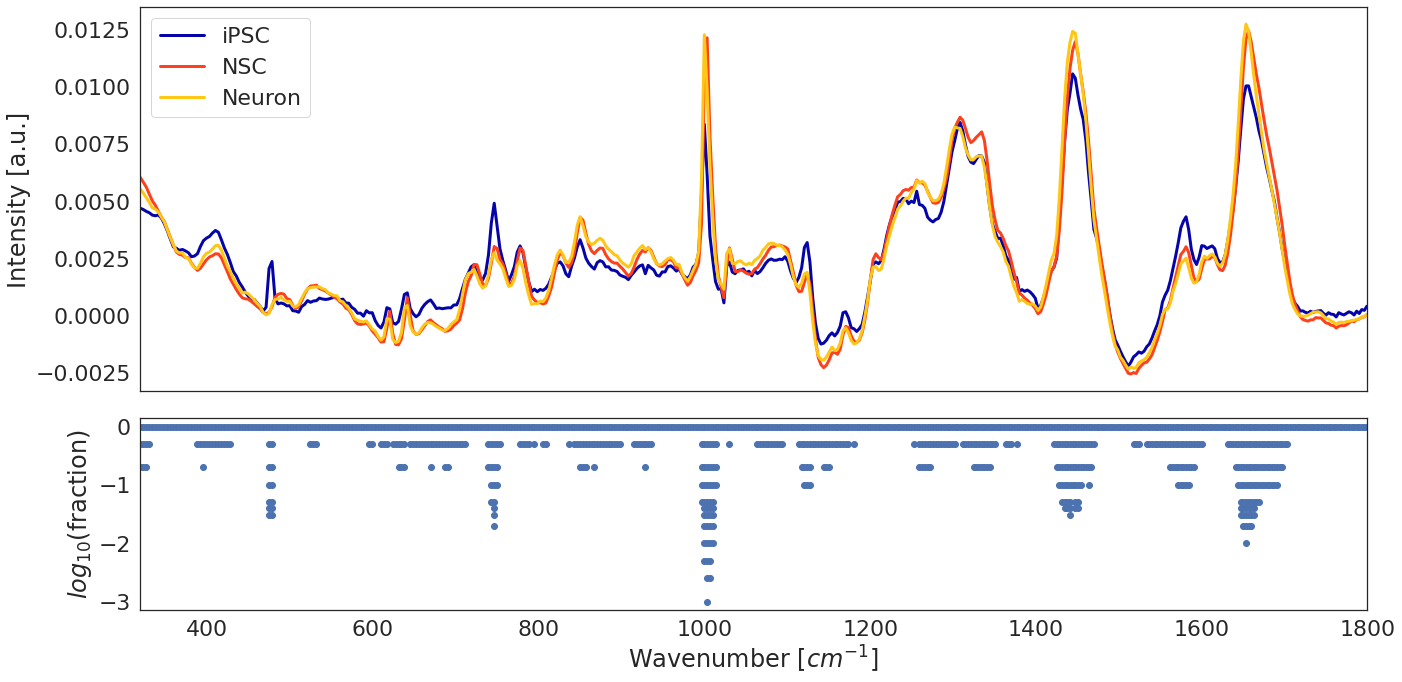

In [320]:
sns.set(style='white',font_scale=2)

fig, ax  = plt.subplots(figsize=[20,10],nrows=2,sharex=True,gridspec_kw={'height_ratios': [2, 1]})

ax[0].plot(spectra_ctype.loc['iPSC',:],'-',color=mypalette[0],lw=3,label='iPSC');
ax[0].plot(spectra_ctype.loc['NSC',:],'-',color=mypalette[1],lw=3,label='NSC');
ax[0].plot(spectra_ctype.loc['Neuron',:],'-',color=mypalette[2],lw=3,label='Neuron');
ax[0].set_xlim([319,1800])
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].legend()

ax[1].plot(top_freqs_df['freq'],np.log10(top_freqs_df['top']),'o')
ax[1].set_xlim([319,1800])
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('$log_{10}$(fraction)')

plt.tight_layout()

fig.savefig('./figures/FigS4.png')

**Figure S4, Identification of most informative frequencies**
Top: Average Raman spectra for each cell type. Bottom: Frequencies with the most variable intensity across average spectra (standard deviation). The fraction of included frequencies is indicated on the y-axis.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5 #number of runs per condition

std = spectra_ctype.std(axis=0) 

mod = ['svm','nn']
freqchoice = ['best','random']

acc = { m : {f : {top : list() for top in tops} for f in freqchoice} for m in mod}

allNtop = list()


for top in tops:
    
    print(top)
    
    # choose frequencies with most variable signal
    q = np.quantile(std,1-top)
    is_top_freq = (std >= q).values
    Ntop = sum(is_top_freq)
    allNtop.append(Ntop)
    
    for m in mod:
        for f in freqchoice:
            
            if f == 'best':
                X_top = spectra.loc[:,is_top_freq]
            else:
                X_top = spectra.sample(n=Ntop,axis='columns')
            
            for rep in range(Nreps):
                
                if m == 'svm':
                    acc_model, test_index, is_correct = train_svm(X_top,y)
                else:
                    acc_model, test_index, is_correct, history = train_nn(X_top,y)
            
                acc[m][f][top].append(acc_model)

with open('./results/acc_svm_nn_subset.pkl', 'wb') as f:  
    pickle.dump(acc, f)

### Binning and averaging

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5 #number of runs per condition

# size of frequency interval
deltas = [1,5,10,20,40,80,100,200,400]

acc_bin = { m : {delta : list() for delta in deltas} for m in mod}

allNbin = list()

for delta in deltas:

    print(delta)

    
    # average over frequency bands for individual spectra        
    spec_mean = pd.DataFrame()

    for i in range(int(spectra.shape[1]/delta)):
        spec_mean = pd.concat((spec_mean,spectra.iloc[:,delta*i:min([spectra.shape[1],delta*(i+1)])].mean(axis=1)),axis=1)

    
    for rep in range(Nreps):
        acc_model, test_index, is_correct = train_svm(spec_mean,y)
        acc_bin['svm'][delta].append(acc_model)
        acc_model, test_index, is_correct,history = train_nn(spec_mean,y)
        acc_bin['nn'][delta].append(acc_model)
            
    allNbin.append(spec_mean.shape[1])

    


with open('./results/acc_svm_nn_binned.pkl', 'wb') as f:  
    pickle.dump(acc_bin, f)


Compare approaches

In [299]:
acc_mean = { m : {f : {top : np.mean(acc[m][f][top]) for top in tops} for f in freqchoice} for m in mod}

acc_mean_df = pd.DataFrame({'SVM,best' : acc_mean['svm']['best'].values(), 'SVM,random' : acc_mean['svm']['random'].values(),
          'NN,best' : acc_mean['nn']['best'].values(), 'NN,random' : acc_mean['nn']['random'].values()},index=allNtop)


acc_bin_mean = { m : {delta : np.mean(acc_bin[m][delta]) for delta in deltas} for m in mod}


acc_bin_mean_df = pd.DataFrame({'SVM,binned' : acc_bin_mean['svm'].values(), 
          'NN,binned' : acc_bin_mean['nn'].values()},index=allNbin)


In [379]:
all_acc_df = pd.concat([acc_mean_df,acc_bin_mean_df]).reset_index().sort_values(by='index').melt(id_vars=['index'])
# all_acc_df.iloc[:,0] = np.log10(all_acc_df.iloc[:,0]) 
all_acc_df.columns = ['N_measurements','Approach','Accuracy']
all_acc_df['model'] = [s.split(',')[0] for s in all_acc_df.Approach]
all_acc_df['selection'] = [s.split(',')[1] for s in all_acc_df.Approach]
all_acc_df.drop('Approach',axis=1,inplace=True)

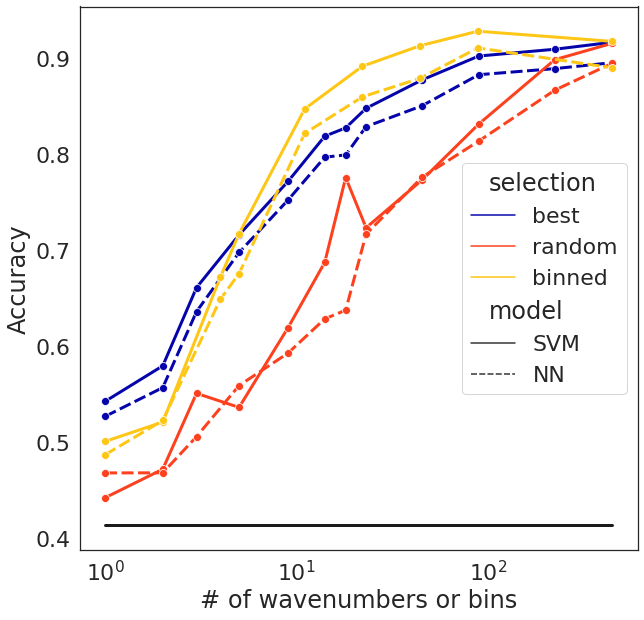

In [405]:
sns.set(style='white',font_scale=2)
fig,ax = plt.subplots(figsize=[10,10])
s = sns.lineplot(data=all_acc_df.sort_values(by='N_measurements'),x='N_measurements',y='Accuracy',hue='selection',
             style= 'model',marker='o',markersize=8,lw=3,palette=mypalette,ax=ax)


s.set(xscale='log')
# xticks = [1, 2, 3, 4, 5, 9, 18, 22, 44, 88, 222, 443]
# s.set(xticks = xticks,xticklabels = [str(x) for x in xticks])

ax.plot([1,Nfreq],[base_acc,base_acc],'k-',lw=3);

ax.set_xlabel('# of wavenumbers or bins');
fig.savefig('./figures/Fig3.png')

**Figure 3, Classification performance increases with number of included frequencies or frequency bins**
Accuracy on a held-out test set of for the support vector machine (SVM) or neural network (NN) model. For the results labeled 'best' or 'random', a subset of frequencies was chosen either based on most variable freqencies ('best') or randomly ('random'). For the results labeled 'binned' Raman intensities were binned in equally sized bins and averaged. The solid horizontal line indicates the base accuracy corresponding to a naive model that always predicts the most abundant class.

# Optimal filter design with an NN

Idea: constrain weights in input layer of NN to be at least non-negative, but ideally also binary, so that they can be implemented in a physical optical filter

### Using the raw data directly

In [471]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [472]:
X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5

acc_svm = 0

for i in range(Nreps):
    acc_svm_run,index_svm,is_correct_svm,y_pred,y_test = train_svm(X,y,norm=False)
    acc_svm += acc_svm_run
    
acc_svm /= Nreps
print(acc_svm)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = [1,2,3,4,5,10,15,20,50,100,400]
Nfilters = [4]
Nreps = 10

constraints = ['non negative','binary']
norms = ['layer','batch']
norms = ['layer']

acc_filter = { Nfilter : 
                    {norm : 
                         {const : list() 
                         for const in constraints}
                     for norm in norms} 
              for Nfilter in Nfilters}


for Nfilt in Nfilters:
    
    print(Nfilt)
    
    for norm in norms:
        
        for i in range(Nreps):
            acc_nonneg, test_index, is_correct,y_pred,y_test, weights, history_nonneg = train_nn_filter(X,y,random_state=9,
                                                                                            Nfilters=Nfilt, norm = norm, 
                                                                                            epochs=200,batch_size=16)
            
            acc_binary, test_index, is_correct, y_pred,y_test, weights, history_binary = train_nn_filter(X,y,random_state=9,
                                                                                        Nfilters=Nfilt,norm=norm, 
                                                                                        constraint='Binary',preweights=weights,
                                                                                         epochs=200,batch_size=16)

            acc_filter[Nfilt][norm]['non negative'].append(acc_nonneg)
            acc_filter[Nfilt][norm]['binary'].append(acc_binary)
            
            print(acc_filter)
            
            if acc_binary < 0.5:
                break
            

with open('./results/acc_filter.pkl', 'wb') as f:  
    pickle.dump(acc_filter, f)

4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [464]:
# plt.plot(history_nonneg.history['accuracy'],'.b')
# plt.plot(history_nonneg.history['val_accuracy'],'.r')
# plt.plot(history_binary.history['accuracy'],'.b')
# plt.plot(history_binary.history['val_accuracy'],'.r')

[0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366031647,
 0.4135338366

In [411]:
# file = open('./results/acc_filter.pkl','rb')
# acc_filter = pickle.load(file)
# file.close()


acc_filter_df = pd.DataFrame.from_dict({(norm,const,Nfilter) : acc_filter[Nfilter][norm][const]
                                    for norm in norms
                                    for const in constraints
                                    for Nfilter in Nfilters},orient='index').melt(ignore_index=False)
                        
acc_filter_df.index = pd.MultiIndex.from_tuples(acc_filter_df.index,names=['normalization','constraint','# filters'])                        
acc_filter_df = acc_filter_df.reset_index().drop('variable',axis=1)
acc_filter_df['condition'] = acc_filter_df['normalization'] + ' , ' + acc_filter_df['constraint'] 

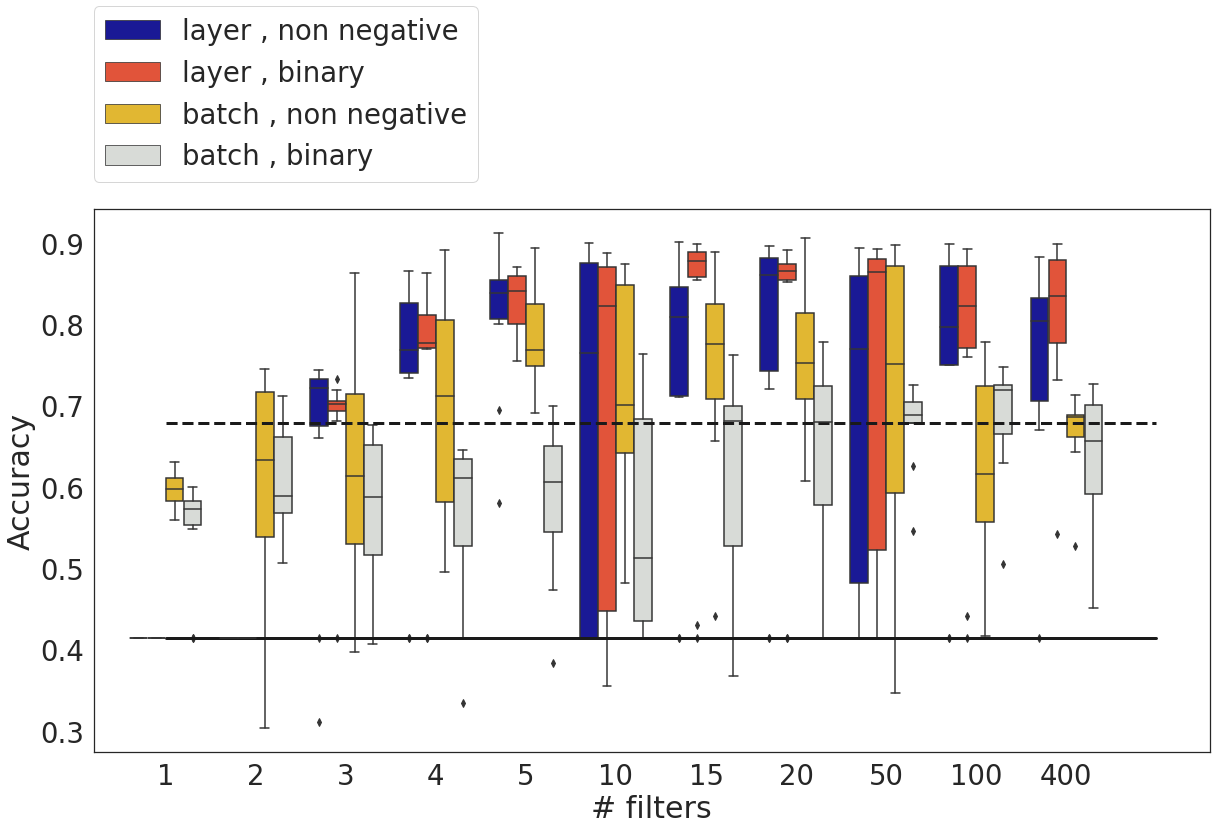

In [412]:
fig,ax = plt.subplots(figsize=[20,10])
s = sns.boxplot(data=acc_filter_df,x='# filters',y='value',hue='condition',ax=ax,palette=mypalette)
ax.plot([0,11],[base_acc,base_acc],'k-',lw=3);
ax.plot([0,11],[acc_svm,acc_svm],'k--',lw=3);
# s.set(xscale='log')
ax.set_ylabel('Accuracy')
ax.legend(bbox_to_anchor=(0, 1.05), loc=3, borderaxespad=0.)

fig.savefig('./figures/Fig4_ver1.png')

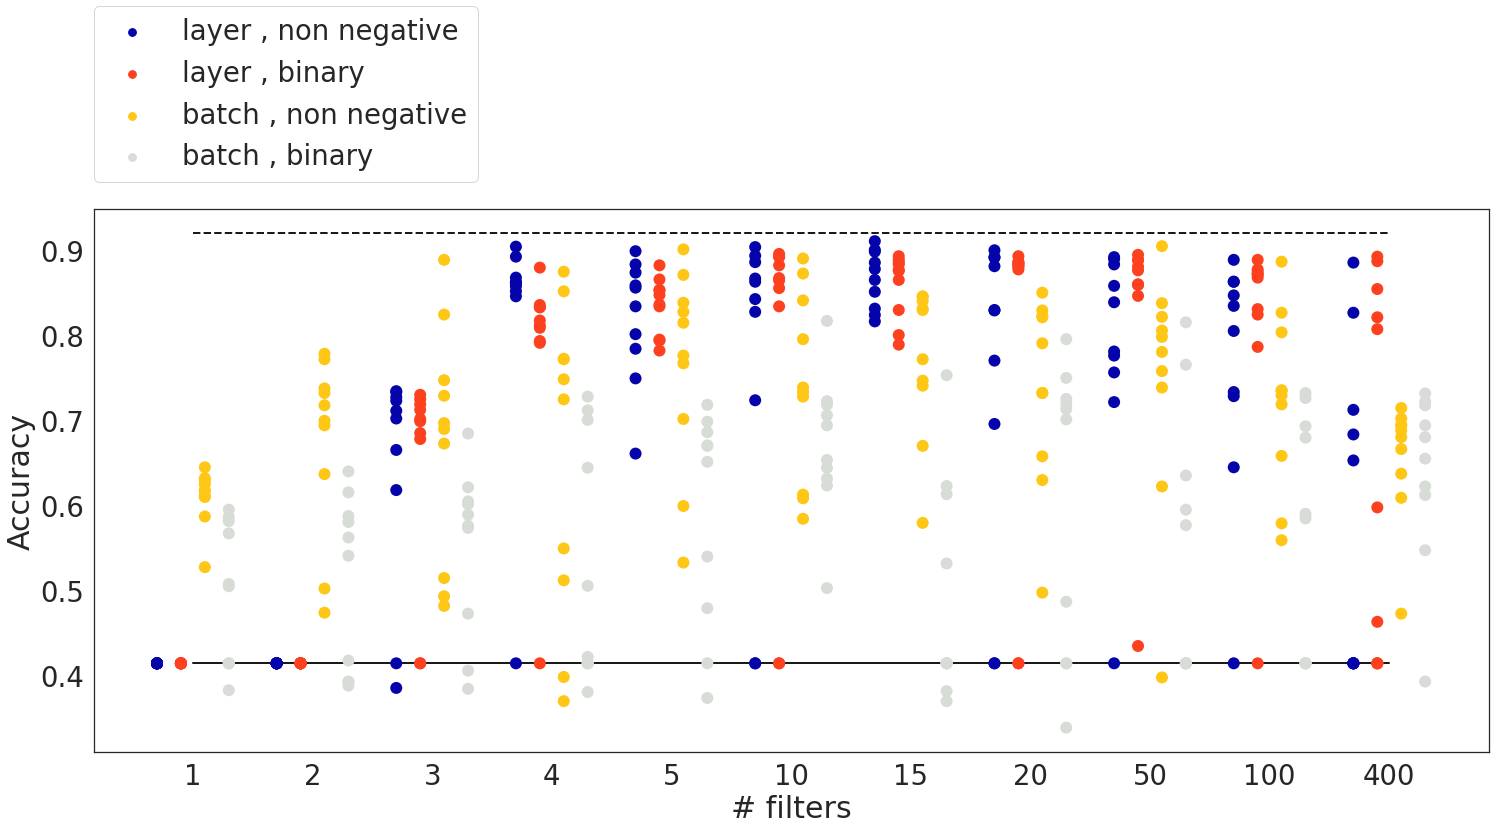

In [158]:
acc_filter_df_plot = acc_filter_df.copy()

        
fig,ax = plt.subplots(figsize=[25,10])
# s = sns.scatterplot(data=acc_filter_df_plot,x='# filters',y='value',hue='normalization',
#                 style='constraint',palette=mypalette,ax=ax,s=100)

# s = sns.scatterplot(data=acc_filter_df_plot,x='# filters',y='value',hue='condition',
#                         palette=mypalette,ax=ax,s=100)

s = sns.stripplot(data=acc_filter_df_plot,x='# filters',y='value',hue='condition',jitter=False,dodge=True,
                        palette=mypalette,ax=ax,s=12)



ax.plot([0,10],[base_acc,base_acc],'k-',lw=2);
ax.plot([0,10],[acc_svm,acc_svm],'k--',lw=2);
# s.set(xscale='log')
ax.set_ylabel('Accuracy')
ax.legend(bbox_to_anchor=(0, 1.05), loc=3, borderaxespad=0.)

fig.savefig('./figures/Fig4_ver2.png')


# Explore classification with 4 filters

In [307]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = 4
acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X,y,Nfilters=Nfilters,
                                                                                     epochs=100,batch_size=8,random_state=42)

acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X,y,Nfilters=Nfilters, 
                                                                            constraint='Binary',preweights=weights_nonneg,
                                                                                epochs=100,batch_size=8,random_state=42)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


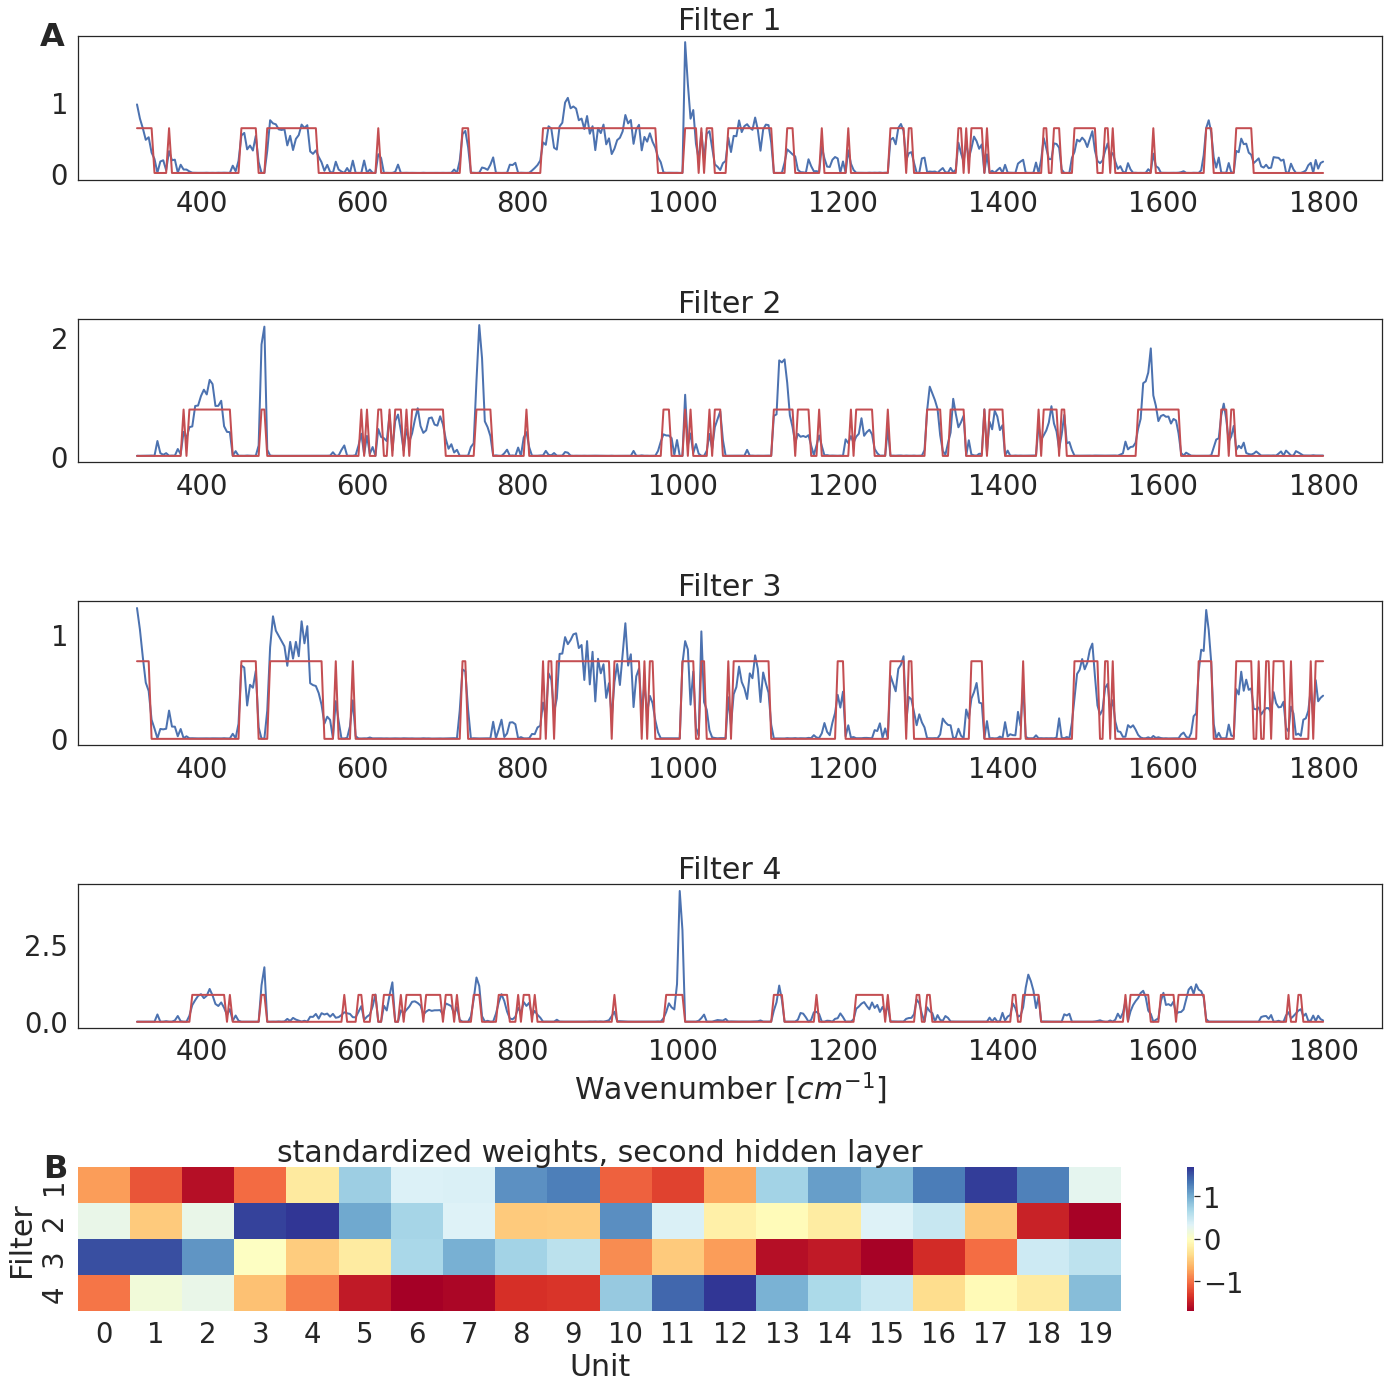

In [352]:
fig,ax = plt.subplots(figsize=[20,5*Nfilters],nrows=Nfilters+1)

panel_label(ax[0],'A')

for i in range(Nfilters):
    ax[i].plot(spectra.columns,weights_nonneg[0][:,i],lw=2)
    ax[i].plot(spectra.columns,weights_binary[0][:,i],'r',lw=2)

    ax[i].set_title('Filter ' + str(i+1))
    
ax[3].set_xlabel('Wavenumber $[ cm^{-1} ]$')

panel_label(ax[Nfilters],'B')


weights_scaled = StandardScaler().fit_transform(weights_binary[4][:,ind])
Z = hierarchy.average(weights_scaled.T)
ind = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, weights_scaled.T))

s = sns.heatmap(weights_scaled[:,ind],yticklabels = ['1','2','3','4'], cmap='RdYlBu',ax=ax[Nfilters])
s.set(xlabel='Unit', ylabel='Filter')

ax[Nfilters].set_title('standardized weights, second hidden layer')

plt.tight_layout()


fig.savefig('./figures/FigS5.png')

In [309]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

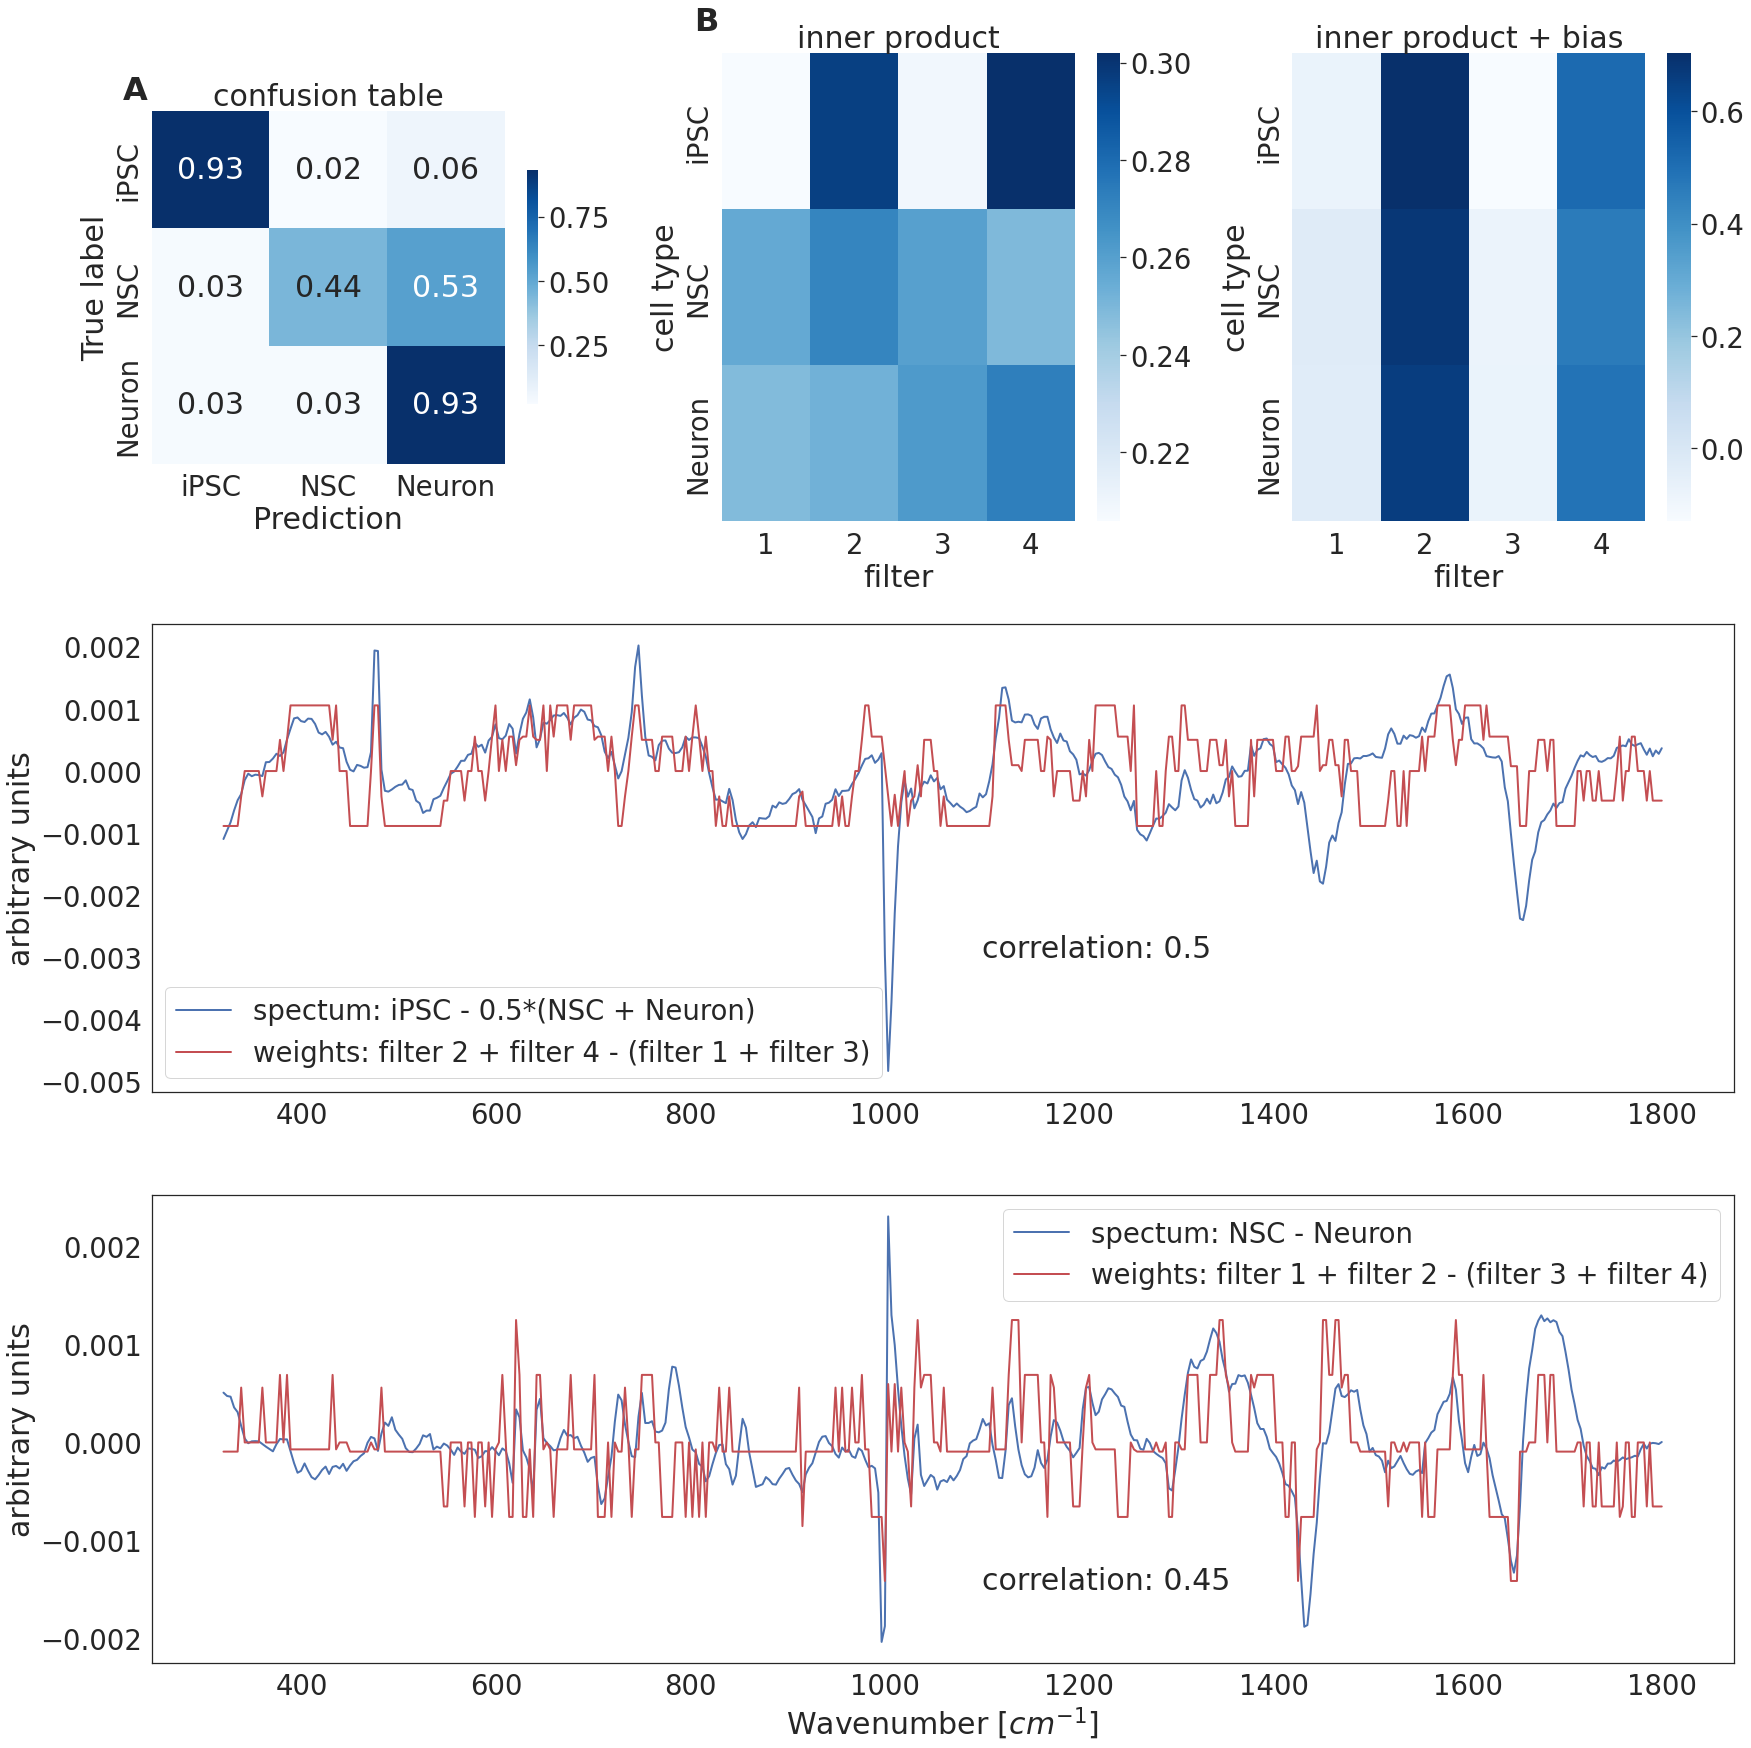

In [363]:
fig,ax = plt.subplots(figsize=[25,25],ncols=3,nrows=3)

panel_label(ax[0,0],'A')

conf_nn_filter = np.round(confusion_matrix(y_test,y_pred,labels = [0,1,2],normalize='true'),2)


s = sns.heatmap(conf_nn_filter,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax[0,0])

s.set(xlabel='Prediction', ylabel='True label');

ax[0,0].set_title('confusion table')



panel_label(ax[0,1],'B')

activ_dict = {
    'no bias' : {str(i+1) :  np.dot(spectra,weights_binary[0][:,i]) for i in range(Nfilters)},
    'complete' : {str(i+1) :  np.dot(spectra,weights_binary[0][:,i]) + weights_binary[1][i] for i in range(Nfilters)}
}



count = 1

for key in activ_dict.keys():

    activ_df = pd.DataFrame(activ_dict[key])
    activ_df['cell type'] =  meta['ctype']
    activ_table = activ_df.groupby('cell type').mean()
    s = sns.heatmap(activ_table,cmap='Blues',ax=ax[0,count])
    s.set(xlabel='filter')
    count+=1

plt.tight_layout()

ax[0,1].set_title('inner product')
ax[0,2].set_title('inner product + bias');


panel_label(ax[1,0],'C')

gs = ax[1, 0].get_gridspec()

for a in ax[1,:]:
    a.remove()

axbig = fig.add_subplot(gs[1,:])

delspec = spectra_ctype.loc['iPSC',:] -  0.5*(spectra_ctype.loc['NSC',:] +spectra_ctype.loc['Neuron',:])

delweights = weights_binary[0][:,1] + weights_binary[0][:,3] - weights_binary[0][:,0] - weights_binary[0][:,2]
delweights = delweights*(np.mean(np.abs(delspec)))/np.mean(np.abs(delweights))

axbig.plot(spectra.columns,delspec,'b',lw=2,label = 'spectum: iPSC - 0.5*(NSC + Neuron)' )
axbig.plot(spectra.columns,delweights,'r',lw=2,label='weights: filter 2 + filter 4 - (filter 1 + filter 3)')
axbig.legend()

axbig.text(1100,-0.003,'correlation: ' + str(np.round(np.corrcoef(delweights,delspec)[0,1],2)))


axbig.set_ylabel('arbitrary units');

gs = ax[2, 0].get_gridspec()

for a in ax[2,:]:
    a.remove()

axbig = fig.add_subplot(gs[2,:])

delspec = spectra_ctype.loc['NSC',:]  - spectra_ctype.loc['Neuron',:]

delweights = weights_binary[0][:,0] + weights_binary[0][:,1] - weights_binary[0][:,2] - weights_binary[0][:,3]
delweights = delweights*(np.mean(np.abs(delspec)))/np.mean(np.abs(delweights))


axbig.plot(spectra.columns,delspec,'b',lw=2,label = 'spectum: NSC - Neuron' )
axbig.plot(spectra.columns,delweights,'r',lw=2,label='weights: filter 1 + filter 2 - (filter 3 + filter 4)')
axbig.legend()

axbig.set_xlabel('Wavenumber $[ cm^{-1} ]$');
axbig.set_ylabel('arbitrary units');

axbig.text(1100, -0.0015, 'correlation: ' + str(np.round(np.corrcoef(delweights,delspec)[0,1],2)))

plt.tight_layout()

fig.savefig('./figures/Fig5.png')

# Generalization from one cell line to another

In [393]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

## Train on two cell lines, predict the third

In [395]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = 4

clines = list(set(meta['cline']))
acc_cline_across = list()

for cline in clines:
    is_train = (meta['cline'] != cline)


    acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X,y,Nfilters=Nfilters,
                                                                                         epochs=100,batch_size=8,is_train=is_train)

    acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X,y,Nfilters=Nfilters, 
                                                                                constraint='Binary',preweights=weights_nonneg,
                                                                                    epochs=100,batch_size=8,is_train=is_train)

    acc_cline_across.append(acc_binary)     

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [397]:
np.mean(acc_cline_across)

0.6627800464630127

## Train and predict within a cell line

In [398]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = 4

clines = list(set(meta['cline']))
acc_cline_within = list()

for cline in clines:
    is_cline = (meta['cline'] != cline)


    acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X.loc[is_cline,:],y[is_cline],
                                                                                                       Nfilters=Nfilters,
                                                                                                 epochs=100,batch_size=8)

    acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X.loc[is_cline,:],y[is_cline],
                                                                                                       Nfilters=Nfilters, 
                                                                                        constraint='Binary',preweights=weights_nonneg,
                                                                                            epochs=100,batch_size=8)

    acc_cline_within.append(acc_binary)     

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [400]:
np.mean(acc_cline_within)

0.8195122679074606